In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dmol
from dmol import color_cycle

In [2]:
int(color_cycle[0][1:], 16)/256**2

68.26666259765625

In [3]:
vertex_colors = []
for c in color_cycle:
    hex_color = int(c[1:], 16)
    r = hex_color // 256**2
    hex_color = hex_color - r* 256**2
    g = hex_color //256
    hex_color = hex_color - g * 256
    b = hex_color
    vertex_colors.append((r/256, g/256, b/256))
vertex_colors = np.array(vertex_colors)

In [4]:
def z6_fxn(x):
    return vertex_colors[x]

z6_fxn(5)

array([0.5       , 0.8046875 , 0.85546875])

In [5]:
# make weights to be 3 x 3 matrices at each group element
# 3x3 so that we have 3 color channels in and 3 out
weights = np.random.normal(size = (6, 3,3))

def z6_omega(x):
    return weights[x]

z6_omega(4)

array([[ 1.23029068,  1.20237985, -0.38732682],
       [-0.30230275, -1.04855297, -1.42001794],
       [-1.70627019,  1.9507754 , -0.50965218]])

In [6]:
def z6_inv(g):
    return (6-g)% 6

def z6_prod(g1, g2):
     return (g1 + g2) % 6

def conv(f, p):
     
     def out(u):
          g = np.arange(6)

          c = np.sum(np.einsum("ij, ijk->ik", f(z6_prod(u, z6_inv(g))), p(g)), axis=0)
          return c
     
     return out

conv(z6_fxn, z6_omega)(3)

array([ 2.66256433,  2.24592108, -1.13474484])

In [7]:
def z6_fxn_trans(g, f):
    return lambda h: f(z6_prod(z6_inv(g), h))

z6_fxn(3), z6_fxn_trans(4, z6_fxn)(3)

(array([0.9375, 0.375 , 0.375 ]), array([0.5       , 0.8046875 , 0.85546875]))

We will compute $\psi(\mathbb{T}_4(f))$- The network acting on the transformed input function.

In [8]:
trans_element = 4
trans_input_fxn = z6_fxn_trans(trans_element, z6_fxn)
trans_input_out = conv(trans_input_fxn, z6_omega)

Now we compute $\mathbb{T}_4\psi(f(x))$ - The transform acting on the network output.

In [9]:
output_fxn = conv(z6_fxn, z6_omega)
trans_output_out = z6_fxn_trans(trans_element, output_fxn)

print("g -> psi[f(g)], g-> psi(Tgf(g)), g -> Tg psi[f(g)] ")

for i in range(6):

    print(i,
          np.round(conv(z6_fxn, z6_omega)(i), 2),
          np.round(trans_input_out(i), 2),
          np.round(trans_output_out(i), 2))

g -> psi[f(g)], g-> psi(Tgf(g)), g -> Tg psi[f(g)] 
0 [ 1.58  3.71 -3.69] [ 2.59  2.34 -1.97] [ 2.59  2.34 -1.97]
1 [ 4.06  2.55 -3.2 ] [ 2.66  2.25 -1.13] [ 2.66  2.25 -1.13]
2 [ 2.59  2.34 -1.97] [ 4.16  0.82 -2.78] [ 4.16  0.82 -2.78]
3 [ 2.66  2.25 -1.13] [ 2.9   2.33 -2.6 ] [ 2.9   2.33 -2.6 ]
4 [ 4.16  0.82 -2.78] [ 1.58  3.71 -3.69] [ 1.58  3.71 -3.69]
5 [ 2.9   2.33 -2.6 ] [ 4.06  2.55 -3.2 ] [ 4.06  2.55 -3.2 ]


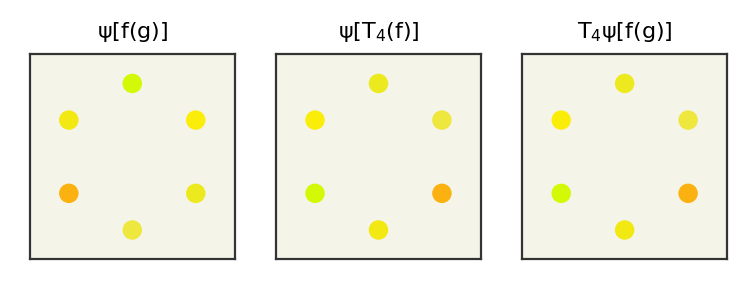

In [11]:
c1 = conv(z6_fxn, z6_omega)
c2 = trans_input_out
c3 = trans_output_out

titles = [r"$\psi\left[f(g)\right]$",
          r"$\psi\left[\mathbb{T}_4(f)\right]$",
          r"$\mathbb{T}_4\psi\left[f(g)\right]$",
          ]

def sigmoid(x):
    return 1/(1 + np.exp(-1*x))

def convert_color(r, g, b):
    h = int(sigmoid(r)* 256**3 + sigmoid(g)* 256**2 + sigmoid(b)* 256)
    return "#{:6X}".format(h)

c1 = [sigmoid(c1(i)) for i in range(6)]
c2 = [sigmoid(c2(i)) for i in range(6)]
c3 = [sigmoid(c3(i)) for i in range(6)]

fig, axs = plt.subplots(1,3, squeeze= True)
points = np.array([(0,1),
                   (0.5*np.sqrt(3), 0.5),
                   (0.5*np.sqrt(3), -0.5),
                   (0, -1),
                   (-0.5*np.sqrt(3), -0.5),
                   (-0.5*np.sqrt(3), 0.5),
                   ])

for i in range(3):
    axs[i].scatter(points[:,0], points[:, 1], color= [c1, c2, c3][i])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlim(-1.4, 1.4)
    axs[i].set_ylim(-1.4, 1.4)
    axs[i].set_aspect("equal")
    axs[i].set_title(titles[i], fontsize = 8)

plt.show()


$G-$ Equivariant Convolutions with Translation

In [12]:
from functools import lru_cache, wraps

def np_cache(*args, **kwargs):
    """LRU cache implementation for functions whose first parameter is a numpy array
    >>> array = np.array([[1,2,3], [4,5,6]])
    >>> @np_cache(maxsize =256)
    ... def multiply(array, factor):
    ...     print("Calculating...")
    ...     return factor*array
    >>> multiply(array, 2)
    Calculating...
    array([[2,4,6],
    [8, 10, 12]])
    >>> multiply(array, 2)
    array([[2,4,6],
    [8, 10, 12]])
    >>> multiply.cache_info()
    CacheInfo(hits =1, misses=1, maxsize=256, currsize =1)
    """

    def decorator(function):
        @wraps(function)
        def wrapper(np_array, *args, **kwargs):
            hashable_array = array_to_tuple(np_array)
            return cached_wrapper(hashable_array, *args, **kwargs)
        
        @lru_cache(*args, **kwargs)
        def cached_wrapper(hashable_array, *args, **kwargs):
            array = np.array(hashable_array)
            return function(array, *args, **kwargs)
        
        def array_to_tuple(np_array):
            """Iterates recursively"""
            try:
                return tuple(array_to_tuple(_) for _ in np_array)
            except TypeError:
                return np_array
        
        # copy lru_cache attributes over too
        wrapper.cache_info = cached_wrapper.cache_info
        wrapper.cache_clear = cached_wrapper.cache_clear

        return wrapper
    
    return decorator 


In [13]:
# load image and drop alpha channel
W= 32
try:
    func_vals = plt.imread("quadimg.png")[...,:3]
except FileExistsError as e:
    import urllib.request
    urllib.request.urlretrieve("https://raw.githubusercontent.com/whitead/dmol-book/main/dl/quadimg.png", "quadimg.png",
                               )
    func_vals = plt.imread("quadimg.png")[...,:3]

func_vals = np.pad(
    func_vals, ((1,1), (1,1), (0,0)), mode= "constant", constant_values=0.2

)

def pix_func(x):
    # clip & squeeze & round to account for transformed values
    xclip = np.squeeze(np.clip(np.round(x), -W//2 -1, W//2)).astype(int)
    # points are centered, fix that
    xclip+= [W//2, W//2, 0]
    # add 1 to account for padding

    return func_vals[xclip[...,0]+1, xclip[...,1]+1]

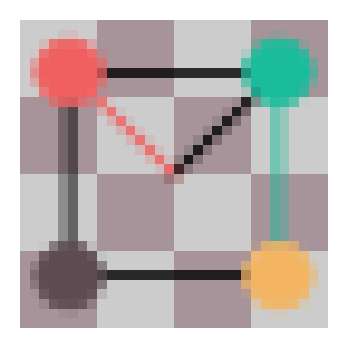

In [14]:
def plot_func(f, ax= None):
    if ax is None:
        plt.figure(figsize=(2,2))
        ax = plt.gca()
    gridx, gridy = np.meshgrid(np.arange(-W//2, W//2), np.arange(-W//2, W//2), indexing="ij")
    # make it into batched x, y indices and add dummy 1 indices for augmented space
    batched_idx = np.vstack( (gridx.flatten(), gridy.flatten(), np.ones_like(gridx.flatten()))).T
    ax.imshow(f(batched_idx).reshape(W, W, 3), origin= "upper")
    ax.axis("off")

plot_func(pix_func)

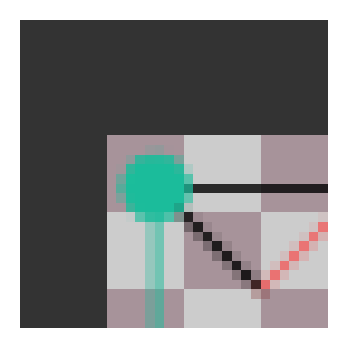

In [34]:
def make_h(rot, mirror):
    """Make h subgroup element"""
    m = np.eye(3)
    if mirror:
        m = np.array([[-1, 0, 0], [0,1,0], [0,0,1]])
    r = np.array([[np.cos(rot), -np.sin(rot), 0], [np.sin(rot), np.cos(rot), 0], [0,0,1]])
    return r @ m

def make_n(dx, dy):
    """Make normal subgroup element"""
    return np.array([[1, 0, dx], [0,1,dy], [0,0,1]])

def g_func_trans(g,f):
    """compute g-function transform"""
    @np_cache(maxsize = W**3)
    def fxn(x, g=g, f=f):
        ginv = np.linalg.inv(g)
        return f(ginv.reshape(1,3,3)@ x.reshape(-1,3,1))
    return fxn

g = make_h(np.pi, 1) @ make_n(12, -8)
tfunc = g_func_trans(g, pix_func)
plot_func(tfunc)

In [63]:
# enumerate stabilizer subgroup (rotation/mirrors)
stabilizer = []
for i in range(4):
    for j in range(2):
        stabilizer.append(make_h(i*np.pi/2, j))

def lift(f):
    """Lift f into group"""
    # create new function from original
    # that is f(gx_0)
    @np_cache(maxsize=W**3)
    def fxn(g, f=f):
        return f(g@ np.array([0,0,1]))
    
    return fxn

def project(f):
    """create projected function space"""
    @np_cache(maxsize = W**3)
    def fxn(x, f=f):
        # x may be batched so we have allow it to be N x3
        x = np.array(x).reshape((-1, 3))
        out = np.zeros((x.shape[0], 3))

        for i, xi in list(enumerate(x)):
            # find coset gH
            lg = make_n(xi[0], xi[1])
            # loop over coset
            for h in stabilizer:
                ghi = lg@h
                out[i] += f(ghi)
            out[i]/= len(stabilizer)
        return out
    return fxn

print("lifted", lift(pix_func)(g))
print("projected", project(lift(pix_func))([12, -8, 0]))

lifted [0.93333334 0.7176471  0.43137255]
projected [[0.72941178 0.71764708 0.72156864]]


In [1]:
-5//2

-3

In [86]:
kernel_width = 5
# make some random values for kernel (untrained)
# kernel is group elements X 3 X 3. The group elements are: N X 5 X 5

kernel = np.random.uniform(-0.5, 0.5, size = (len(stabilizer), kernel_width, kernel_width, 3, 3))

def conv(f, p=kernel):
    @np_cache(maxsize = W**4)
    def fxn(u):
        result = 0
        for hi, h in enumerate(stabilizer):
            for nix in range(-kernel_width//2, kernel_width//2 ):
                for niy in range(-kernel_width//2, kernel_width//2):
                    result += (f(u@ make_n(-nix, -niy)@ np.linalg.inv(h))
                               @ kernel[hi, nix+kernel_width//2, niy+kernel_width//2] )
        
        return sigmoid(result)
    
    return fxn

cout = conv(lift(pix_func))

cout(g)

array([0.53496952, 0.00421064, 0.99956141])

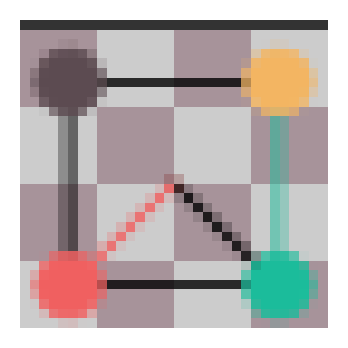

In [87]:
def plot_coset(h, f, ax):
    """plot a function over group elements on cosets given representative"""
    gridx, gridy = np.meshgrid(np.arange(-W//2, W//2), np.arange(-W//2, W//2), indexing="ij")

    batched_idx = np.vstack( (gridx.flatten(), gridy.flatten(), np.ones_like(gridx.flatten()))).T
    values = np.zeros((W**2, 3))
    for i, bi in enumerate(batched_idx):
        values[i] = f(h@ make_n(bi[0], bi[1]))
    ax.imshow(values.reshape(W, W, 3), origin= "upper")
    ax.axis("off")

plt.figure(figsize=(2,2))
plot_coset(make_h(0,1), lift(pix_func), ax= plt.gca())

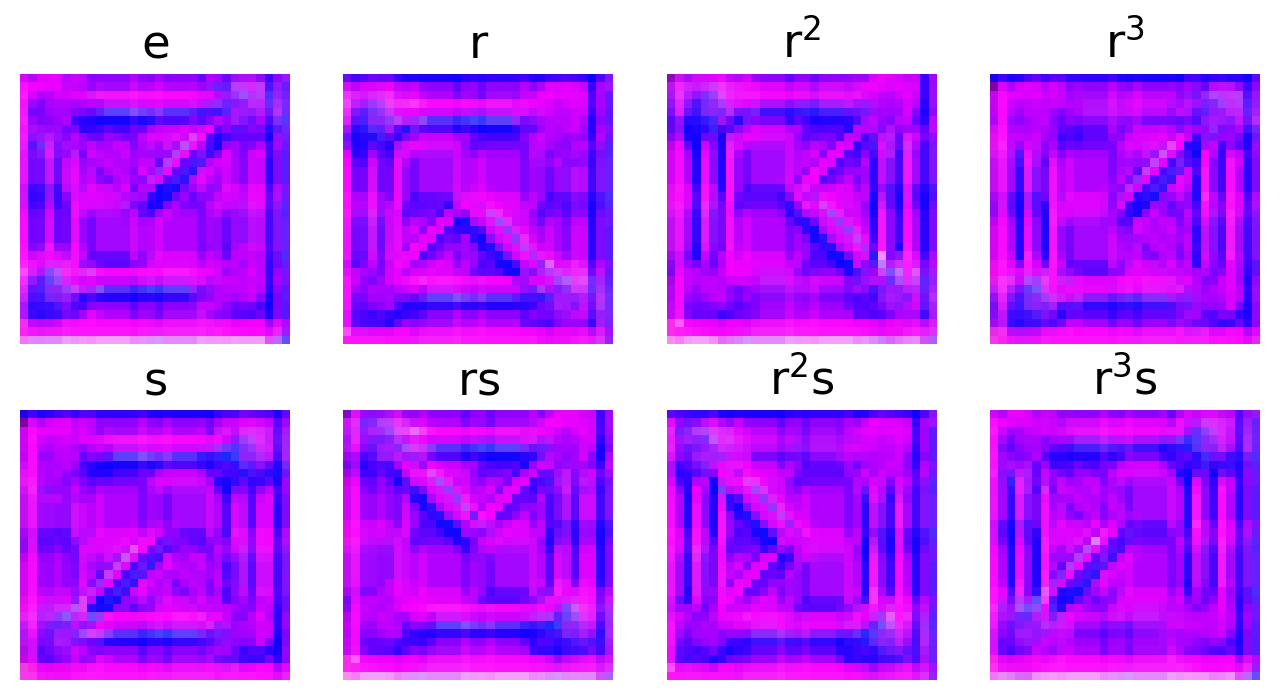

In [88]:
stabilizer_names = ["$e$", "$r$", "$r^2$", "$r^3$", "$s$", "$rs$", "$r^2s$", "$r^3s$"]
fig, axs = plt.subplots(2, 4, figsize= (8,4))
axs = axs.flatten()
for i, (n,h) in enumerate(zip(stabilizer_names, stabilizer)):
    ax = axs[i]
    plot_coset(h, cout, ax)
    ax.set_title(n)

In [90]:
import pycuda.autoinit

ModuleNotFoundError: No module named 'pycuda'

In [81]:
A = np.arange(-1, 4)
B = np.arange(5, 10)
C = np.meshgrid(A, B)


array([[-1,  0,  1,  2,  3],
       [-1,  0,  1,  2,  3],
       [-1,  0,  1,  2,  3],
       [-1,  0,  1,  2,  3],
       [-1,  0,  1,  2,  3]])

In [2]:
# Distance Matrix
import numpy as np
from scipy import linalg
from scipy.spatial.distance import cdist
from sklearn.utils.graph_shortest_path import graph_shortest_path


def make_adjacency(data, dist_func ="euclidean", eps=np.inf):
    n,m = data.shape
    dist = cdist(data.T, data.T, metric = dist_func)
    adj = np.zeros((m,m)) + np.inf
    bln = dist < eps
    adj[bln] = dist[bln]
    short = graph_shortest_path(adj)
    return short

In [ ]:
dist_matrix = make_adjacency(P.T, dist_func= "euclidean", eps= np.inf)

In [101]:
import numpy as np
import scipy as sp
from scipy.stats import ortho_group, special_ortho_group
from scipy.linalg import null_space
from scipy.spatial import distance_matrix
import random
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from procrustes.generic import generic as procrustes
from procrustes.orthogonal import orthogonal as orth_procrustes


# distance

def geodesicDistance(X, k = 15):
    iso = Isomap(n_components = 2,n_neighbors=k)
    return iso.fit(X).dist_matrix_


# greedy permutation

def getGreedyPerm(D):
    # Author: Chris Tralie
    # https://gist.github.com/ctralie/128cc07da67f1d2e10ea470ee2d23fe8
    if D.shape[0] != D.shape[1]:
        D = distance_matrix(D,D)
    N = D.shape[0]
    perm = np.zeros(N, dtype=np.int64)
    lambdas = np.zeros(N)
    ds = D[0, :]
    for i in range(1, N):
        idx = np.argmax(ds)
        perm[i] = idx
        lambdas[i] = ds[idx]
        ds = np.minimum(ds, D[idx, :])
    return (perm, lambdas)


# given distance matrix D and natural number J, returns a cover with J elements
def greedyPermutationCover(D, J, overlap):
    perm, lambdas = getGreedyPerm(D)
    eps = lambdas[J-1]
    #print(lambdas)
    N = D.shape[0]
    cover = {}
    for i in perm[:J]:
        cover[i] = []
        for j in range(N):
            if D[i,j] < overlap * eps :
                cover[i].append(j)
        #cover[i] = np.array(cover[i])
    return perm[:J], cover, overlap * eps


In [1]:
A = [4,5, 0, -1, 9 , 12, -23, 10, 8, 2]
del A[-1]

In [2]:
A

[4, 5, 0, -1, 9, 12, -23, 10, 8]

In [3]:
del A[2, 4, 6 ]

TypeError: list indices must be integers or slices, not tuple

In [ ]:
#indices = list
for i in sorted(indices, reverse=True):
    del data[i]


In [5]:
import numpy as np
A = np.array([[1,2,3], [4,5,6], [7,8,9]])
A = list(A)
del A[0]

In [6]:
A

[array([4, 5, 6]), array([7, 8, 9])]

In [14]:
def fit(self):
    self.graph = tf.Graph()
    with self.graph.as_default():
        self.X = tf.placeholder(self.dtype, shape=self.data.shape)
        # Perform SVD
        singular_values, u, _ = tf.svd(self.X)
        # Create sigma matrix
        sigma = tf.diag(singular_values)
    with tf.Session(graph=self.graph) as session:
        self.u, self.singular_values, self.sigma = session.run([u, singular_values, sigma],
                                                               feed_dict={self.X: self.data})

In [15]:

import numpy as np
def reduce(self, n_dimensions=None, keep_info=None):
    if keep_info:
        # Normalize singular values
        normalized_singular_values = self.singular_values / sum(self.singular_values)
        # Create the aggregated ladder of kept information per dimension
        ladder = np.cumsum(normalized_singular_values)
        # Get the first index which is above the given information threshold
        index = next(idx for idx, value in enumerate(ladder) if value >= keep_info) + 1
        n_dimensions = index
    with self.graph.as_default():
        # Cut out the relevant part from sigma
        sigma = tf.slice(self.sigma, [0, 0], [self.data.shape[1], n_dimensions])
        # PCA
        pca = tf.matmul(self.u, sigma)
    with tf.Session(graph=self.graph) as session:
        return session.run(pca, feed_dict={self.X: self.data})


In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
#tf_pca = TF_PCA(iris_dataset.data, iris_dataset.target)

2023-07-11 10:14:45.570022: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 10:14:46.541238: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-11 10:14:46.541337: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-11 10:14:49.965387: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
class TF_PCA:
    def __init__(self, X):
        self.X = X
        self.u = None
        self.singular_values = None
        self.sigma = None

    def fit(self):
        # Perform SVD
        self.singular_values, self.u, _ = tf.linalg.svd(self.X)

        # Create sigma matrix
        self.sigma = tf.linalg.diag(self.singular_values)

    def reduce(self, n_dimensions=None, keep_info=None):
        if keep_info:
            # Normalize singular values
            normalized_singular_values = self.singular_values / sum(self.singular_values)

            # Create the aggregated ladder of kept information per dimension
            ladder = np.cumsum(normalized_singular_values)

            # Get the first index which is above the given information threshold
            index = next(idx for idx, value in enumerate(ladder) if value >= keep_info) + 1
            n_dimensions = index

        # Cut out the relevant part from sigma
        sigma = tf.slice(self.sigma, [0, 0], [self.X.shape[1], n_dimensions])

        # PCA
        pca = tf.matmul(self.u, sigma)
        return pca, sigma, self.u

In [5]:
import pickle
import numpy as np

with open("features_train", "rb") as f:
        features = np.array(pickle.load(f))

#with open("labels_pca1", "rb") as f:
        #labels = np.array(pickle.load(f))

features= features.reshape(len(features), 1600)

In [6]:
features.shape

(19286, 1600)

2023-07-11 10:20:21.468323: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-11 10:20:21.470054: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-11 10:20:21.471143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-88TBBTR): /proc/driver/nvidia/version does not exist
2023-07-11 10:20:21.482569: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 10:20:21.510511: W tensorflow/tsl/framework/cpu_allocator

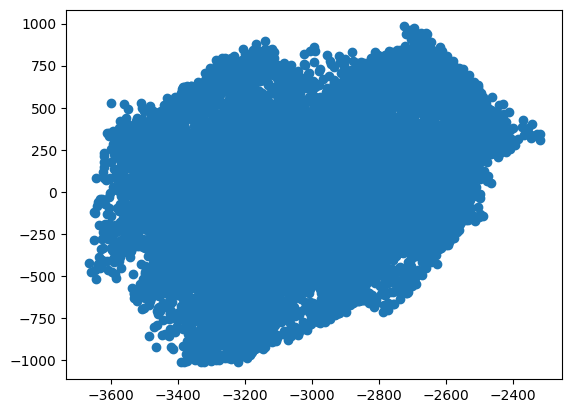

In [7]:
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
tf_pca = TF_PCA(features)
tf_pca.fit()
pca, sigma,u = tf_pca.reduce(n_dimensions=2)  # Results in 2 dimensions
#color_mapping = {0: sns.xkcd_rgb['bright purple'], 1: sns.xkcd_rgb['lime'], 2: sns.xkcd_rgb['ochre']}
#colors = list(map(lambda x: color_mapping[x], iris.target))
plt.scatter(pca[:, 0], pca[:, 1])

In [19]:
import numpy as np
import math
from sklearn.neighbors import KDTree

def dense_sort_data(k, perc):
    #P = np.asarray(Q[0:math.ceil(30/100*len(Q))])

    tree = KDTree(pca, leaf_size =80)
    dist, ind = tree.query(pca, k)

    data_sort1 = list(zip(list(pca), dist[:,k-1]))
    #labels_sort = list(zip(list(labels), dist[:,k-1]))
    train_sort = list(zip(list(features), dist[:,k-1]))
    len_data = len(data_sort1)

    data_sort1.sort(key = lambda x:x[1], reverse = False)
    #labels_sort.sort(key = lambda x:x[1], reverse = False)
    train_sort.sort(key = lambda x:x[1], reverse = False)


    B = list(zip(*data_sort1[0:math.ceil(perc/100*len_data)]))[0]
    #C = list(zip(*labels_sort[0:math.ceil(perc/100*len_data)]))[0]
    D = list(zip(*train_sort[0:math.ceil(perc/100*len_data)]))[0]

    return np.asarray(B),  np.asarray(D)


In [20]:
data_sort, train_sort = dense_sort_data(250, 100)


In [41]:
data_sort[1000]

array([-2757.526  ,   145.32118], dtype=float32)

In [42]:
from scipy.spatial.distance import cdist

a = cdist(np.array([data_sort[1000]]), data_sort)

val = np.argmax(a[0])
eps = a[0][val]

In [76]:
eps

1317.2543522462438

In [54]:
cover = []
N = len(data_sort)
for j in range(N):
    if a[0][j] <= eps/5.4:
        cover.append(j)

In [81]:
len(cover)

3786

In [125]:
fiber = []
for j in cover:
    
    fiber.append(train_sort[j])

fiber_ = []
for i in cover:
    
    fiber_.append(data_sort[i])


a_list = cdist(np.array([data_sort[1000]]), np.asarray(fiber_))
sub_cover = []
n = len(fiber)

for j in range(n):
    if a_list[0][j] <= eps/5.7:
        sub_cover.append(j)


In [124]:
len(fiber)
#len(sub_cover)
fiber = np.asarray(fiber)

In [88]:
fiber_[0]

array([-2908.2754 ,   172.59648], dtype=float32)

In [126]:
train_fiber = fiber
for i in sorted(sub_cover, reverse=True):
    del train_fiber[i]


In [127]:
train_fiber =np.asarray(train_fiber)

In [128]:
train_fiber.shape

(309, 1600)

In [55]:
train_list = list(train_sort)
for i in sorted(cover, reverse=True):
    del train_list[i]


#labels_list = list(labels_sort)
#for i in sorted(cover, reverse=True):
 #   del labels_list[i]



In [56]:
data_array = np.asarray(train_list)
#labels_array = np.asarray(labels_list)

In [97]:
#data_array.shape
train_fiber = list(train_fiber)
train_fiber = np.asarray(train_fiber)

In [16]:
with open('features_pca2','wb') as f:
    pickle.dump(data_array,f,protocol=4)


with open('labels_pca2','wb') as f:
    pickle.dump(labels_array,f,protocol=4)

In [105]:
len(fiber)

791

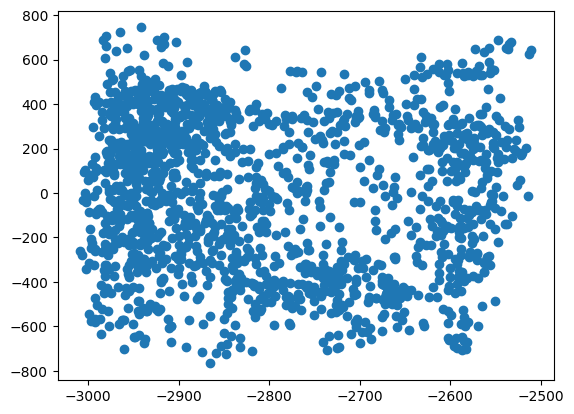

In [122]:
tf_pca = TF_PCA(train_fiber)
tf_pca.fit()
pca_1, sigma,u = tf_pca.reduce(n_dimensions=2)  # Results in 2 dimensions
#color_mapping = {0: sns.xkcd_rgb['bright purple'], 1: sns.xkcd_rgb['lime'], 2: sns.xkcd_rgb['ochre']}
#colors = list(map(lambda x: color_mapping[x], iris.target))
plt.scatter(pca_1[:, 0], pca_1[:, 1])

In [92]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import math
from sklearn.manifold import Isomap
from numpy.linalg import norm
from ripser import ripser
from persim import plot_diagrams
import warnings
warnings.filterwarnings('ignore')

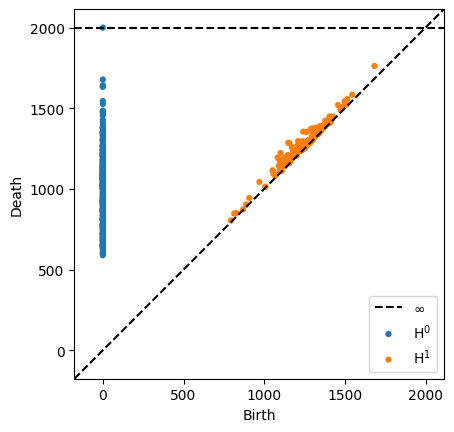

In [130]:
ripser_out_z2 = ripser(train_fiber, coeff=2, do_cocycles = True, maxdim = 1, n_perm = 300)
dgmsz2 = ripser_out_z2['dgms']
plot_diagrams(dgmsz2, labels = ["$H^0$", "$H^1$", "$H^2$", "$H^3$"])
#plt.title("$\beta_1 = 5$")
#plt.savefig("data_diag.png")

In [20]:
A = list(dgmsz2[1])
A.sort(key = lambda x:x[1]-x[0], reverse = True)

In [21]:
A[:20]

[array([1314.54821777, 1625.01940918]),
 array([1306.82629395, 1605.53259277]),
 array([1496.2746582 , 1773.24023438]),
 array([1338.93237305, 1613.47302246]),
 array([1294.95751953, 1568.49414062]),
 array([1319.26867676, 1589.70910645]),
 array([1408.45263672, 1670.58105469]),
 array([1318.31860352, 1564.0501709 ]),
 array([1304.74133301, 1547.94604492]),
 array([1318.29431152, 1560.36572266]),
 array([1302.67956543, 1530.84777832]),
 array([1310.80505371, 1533.60876465]),
 array([1314.9395752 , 1530.75927734]),
 array([1349.48254395, 1558.31762695]),
 array([1264.33618164, 1470.25231934]),
 array([1417.27905273, 1613.41870117]),
 array([1375.97314453, 1568.54650879]),
 array([1305.82458496, 1498.        ]),
 array([1292.2232666 , 1480.95678711]),
 array([1321.81726074, 1509.60754395])]

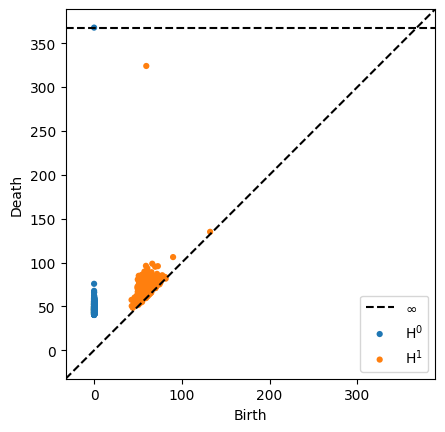

In [24]:
ripser_out_z2 = ripser(pca_1, coeff=2, do_cocycles = True, maxdim = 1, n_perm = 600)
dgmsz2 = ripser_out_z2['dgms']
plot_diagrams(dgmsz2, labels = ["$H^0$", "$H^1$", "$H^2$", "$H^3$"])
#plt.title("$\beta_1 = 5$")
#plt.savefig("data_diag.png")

In [49]:
data_array.shape

(7036, 1600)